## Implementing cloud-top phase retrievals
New data from Olimpia (through Trude) is organized differently. I need to write it to a .nc format so I can make quick comparisons.

In [42]:
import sys
# Add common resources folder to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/")
sys.path.append("/home/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, sys, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics,
    datetime
    )

from functions import (
    masked_average, plot_slf_isotherms,
    season_mean, add_weights, season_mean_dev
    )

%matplotlib inline

In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    model_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(model_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

Running through MC2 Jupyter Hub


## Load annual values with new filters (06/11/2020)

In [14]:
output_dir = 'caliop_olimpia_new/netcdf_format/'
bulk_obs_dir = "caliop_olimpia_new/4_Jonah/bulk3/total/global/"
top_obs_dir = 'caliop_olimpia_new/4_Jonah/top03/total/global/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(bulk_obs_dir) and os.path.exists(top_obs_dir) and os.path.exists(output_dir)
print('Can access all directory paths:', access_paths)

Can access all directory paths: True


In [15]:
os.listdir(bulk_obs_dir)

['slf_count_geo_bulk.npz', 'read_me.txt', 'count_cph_T.npy', 'slf_T.npy']

In [21]:
_npz = np.load("%s%s" % (bulk_obs_dir, 'slf_count_geo_bulk.npz'))
_slf_in = _npz["slf_geo"]
_slf_out = np.moveaxis(_slf_in, 0, -1)

In [48]:
df = np.zeros((180, 360, 9)) # lat, lon, iso

lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-180, 179, 360)
iso = np.linspace(-40, 0, 9)

_npz = np.load("%s%s" % (bulk_obs_dir, 'slf_count_geo_bulk.npz'))
_slf_in = _npz["slf_geo"]
_slf_out = np.moveaxis(_slf_in, 0, -1)
        
df[:,:,:] = _slf_out

da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso},
                  dims=["lat","lon", "isotherm"])
da = da.sortby('isotherm')

da.attrs['long_name'] = "SLF retrieved by CALIOP from within cloud (TAU: 0.0-3.0) "
da.attrs['units'] = "Fraction [0-1]"

ds = xr.Dataset()
ds['SLF'] = da
ds = add_weights(ds)

In [49]:
ds.to_netcdf(path='%s/bulk_slfs_annual.nc' % output_dir)

In [50]:
df = np.zeros((180, 360, 9)) # lat, lon, iso

lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-180, 179, 360)
iso = np.linspace(-40, 0, 9)

_npz = np.load("%s%s" % (top_obs_dir, 'slf_count_geo.npz'))
_slf_in = _npz["slf_geo"]
_slf_out = np.moveaxis(_slf_in, 0, -1)
        
df[:,:,:] = _slf_out

da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso},
                  dims=["lat","lon", "isotherm"])
da = da.sortby('isotherm')

da.attrs['long_name'] = "SLF retrieved by CALIOP from within cloud (TAU: 0.0-3.0) "
da.attrs['units'] = "Fraction [0-1]"

ds = xr.Dataset()
ds['SLF'] = da
ds = add_weights(ds)

In [51]:
ds.to_netcdf(path='%s/ct_slfs_annual.nc' % output_dir)

## Load seasonal values with new filters (06/11/2020)

In [21]:
output_dir = 'caliop_olimpia_new/netcdf_format/'
bulk_obs_dir = "caliop_olimpia_new/4_Jonah/bulk3/season/global/"
top_obs_dir = 'caliop_olimpia_new/4_Jonah/top03/season/global/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(bulk_obs_dir) and os.path.exists(top_obs_dir) and os.path.exists(output_dir)
print('Can access all directory paths:', access_paths)

Can access all directory paths: True


In [22]:
os.listdir(bulk_obs_dir)

['count_T_bulk_season.png',
 'read_me.txt',
 'SON',
 'JJA',
 'slf_T_bulk_season.png',
 'MAM',
 'DJF']

### Bulk-seasonal

In [23]:
df = np.zeros((180, 360, 9, 4)) # lat, lon, iso, season

lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-180, 179, 360)
iso = np.linspace(-40, 0, 9)
time = [datetime(2010, 1, 1),datetime(2010, 7, 1),datetime(2010, 4, 1),datetime(2010, 10, 1)]
season = ['DJF', 'JJA', 'MAM', 'SON'] # weird order
season_dict = {'DJF':datetime(2010, 1, 15), 'JJA':datetime(2010, 7, 15), 
               'MAM':datetime(2010, 4, 15), 'SON':datetime(2010, 10, 15)} # by middle month

cal_seasons = os.listdir(bulk_obs_dir)
cal_seasons.sort()
i=0
for season in cal_seasons:
    if len(season) == 3: # quickly filter out the README
        print(season, time[i])
        obs_files = os.listdir("%s%s" % (bulk_obs_dir,season))
        file_str = '.npz'
        data_file = [x for x in obs_files if file_str in x][0] # weird list/indexing things :(
        print(data_file)
        _npz = np.load('%s%s/%s' % (bulk_obs_dir,season,data_file))
        _slf_in = _npz["slf_geo"]
        _slf_out = np.moveaxis(_slf_in, 0, -1)
        
        df[:,:,:,i] = _slf_out
        i+=1
da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso,
                          "time": time},
                  dims=["lat","lon", "isotherm","time"])
da = da.sortby('isotherm')

da.attrs['long_name'] = "SLF retrieved by CALIOP from within cloud (TAU: 0.0-3.0) "
da.attrs['units'] = "Fraction [0-1]"

ds = xr.Dataset()
ds['SLF'] = da
bulk_ds = add_weights(ds)

DJF 2010-01-01 00:00:00
slf_count_geo_bulk_DJF.npz
JJA 2010-07-01 00:00:00
slf_count_geo_bulk_JJA.npz
MAM 2010-04-01 00:00:00
slf_count_geo_bulk_MAM.npz
SON 2010-10-01 00:00:00
slf_count_geo_bulk_SON.npz


In [24]:
bulk_ds.to_netcdf(path='%s/bulk_slfs_seasonal.nc' % output_dir)

### Cloud top seasonal

In [25]:
df = np.zeros((180, 360, 9, 4)) # lat, lon, iso, season

lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-180, 179, 360)
iso = np.linspace(-40, 0, 9)
time = [datetime(2010, 1, 1),datetime(2010, 7, 1),datetime(2010, 4, 1),datetime(2010, 10, 1)]
season = ['DJF', 'JJA', 'MAM', 'SON'] # weird order
season_dict = {'DJF':datetime(2010, 1, 15), 'JJA':datetime(2010, 7, 15), 
               'MAM':datetime(2010, 4, 15), 'SON':datetime(2010, 10, 15)} # by middle month

cal_seasons = os.listdir(top_obs_dir)
cal_seasons.sort()
i = 0
for season in cal_seasons:
    if len(season) == 3: # quickly filter out the README
        print(season, time[i])
        obs_files = os.listdir("%s%s" % (top_obs_dir,season))
        file_str = '.npz'
        data_file = [x for x in obs_files if file_str in x][0] # weird list/indexing things :(
        print(data_file)
        _npz = np.load('%s%s/%s' % (top_obs_dir,season,data_file))
        _slf_in = _npz["slf_geo"]
        _slf_out = np.moveaxis(_slf_in, 0, -1)
        
        df[:,:,:,i] = _slf_out
        i+=1

da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso,
                          "time": time},
                  dims=["lat","lon", "isotherm","time"])
da = da.sortby('isotherm')

da.attrs['long_name'] = "SLF retrieved by CALIOP from the top lower discarding TAU < 0.3) "
da.attrs['units'] = "Fraction [0-1]"

ds = xr.Dataset()
ds['SLF'] = da
ct_ds = add_weights(ds)

DJF 2010-01-01 00:00:00
slf_count_geo_DJF.npz
JJA 2010-07-01 00:00:00
slf_count_geo_JJA.npz
MAM 2010-04-01 00:00:00
slf_count_geo_MAM.npz
SON 2010-10-01 00:00:00
slf_count_geo_SON.npz


In [26]:
ct_ds.to_netcdf(path='%s/ct_slfs_seasonal.nc' % output_dir)

In [121]:
season_check = season_mean(ct_ds)

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


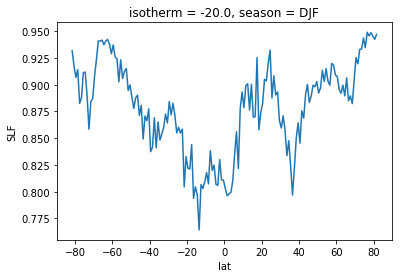

In [122]:
season_check['SLF'][0,:,:,4].mean('lon').plot()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


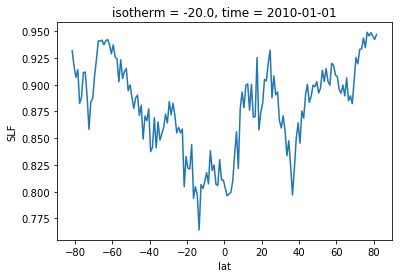

In [41]:
ct_ds['SLF'][:,:,4,0].mean('lon').plot()

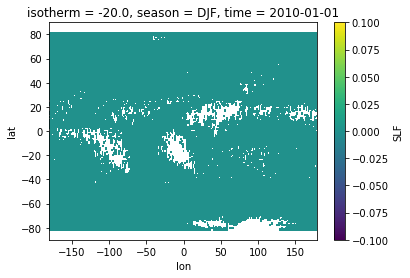

In [39]:
(season_check['SLF'][0,:,:,4] - ct_ds['SLF'][:,:,4,0]).plot()

In [91]:
k = np.ones((2,2,5))

In [94]:
k = np.zeros((2,2,5))

In [95]:
k[1,1,1]=np.nan

In [97]:
k.where(k != np.nan)

AttributeError: 'numpy.ndarray' object has no attribute 'where'

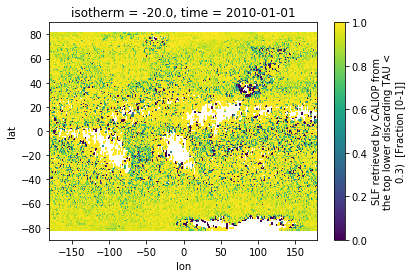

In [100]:
ds.where(ds != np.nan)[:,:,4,0].plot()

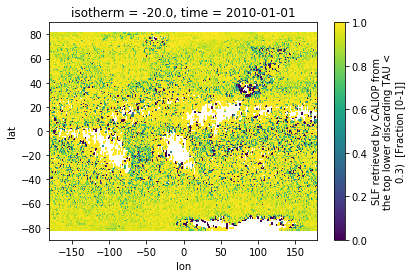

In [101]:
ds[:,:,4,0].plot()

In [51]:
ds,weights = season_mean_dev(ct_ds['SLF'])

In [80]:
scd = (ds * weights).groupby('time.season')

In [114]:
scd.sum('time')

<xarray.DataArray (lat: 180, lon: 360, isotherm: 9, season: 4)>
array([[[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       [[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       [[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]],


       ...,


       [[[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0.],


In [102]:
for i in scd:
    print(i)
    break

('DJF', <xarray.DataArray (lat: 180, lon: 360, isotherm: 9, time: 1)>
array([[[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
  

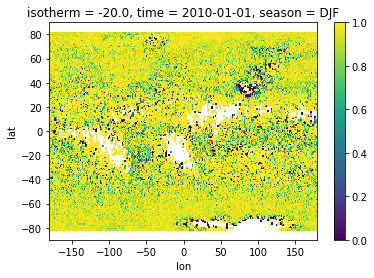

In [111]:
i[1][:,:,4,0].plot()

In [119]:
grp = (ds * weights).groupby('time.season').sum(dim='time', min_count=1)
grp_old = (ds * weights).groupby('time.season').sum(dim='time')

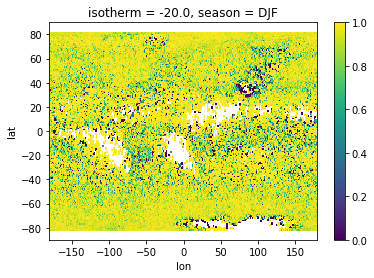

In [118]:
grp[:,:,4,0].plot()

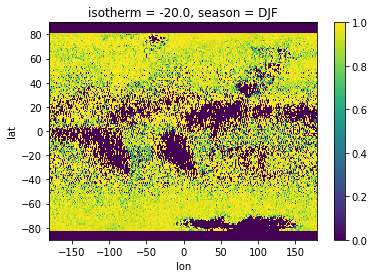

In [120]:
grp_old[:,:,4,0].plot()

In [84]:
grp.where(ds != np.nan)

<xarray.DataArray (lat: 180, lon: 360, isotherm: 9, season: 4, time: 4)>
array([[[[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         ...,

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         ...,

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         ...,

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         ...,

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         ...,

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]]],


        [[[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         [[0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.],
          [0., 0., 0., 0.]],

         ...,

         [[0., 0., 0., 0.],
          [0., 0., 0.,

In [64]:
for i in grp:
    print(i)
    break

('DJF', <xarray.DataArray (lat: 180, lon: 360, isotherm: 9, time: 1)>
array([[[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        ...,

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]]],


       [[[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
         [nan],
         [nan],
         ...,
         [nan],
         [nan],
         [nan]],

        [[nan],
  

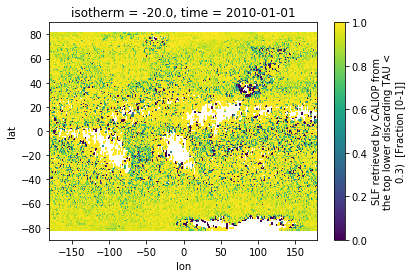

In [55]:
ds[:,:,4,0].plot()

## Load incloud/bulk cloud values. 06/02/2020?


In [12]:
output_dir = 'caliop_olimpia/seasonal_data/'
bulk_obs_dir = "caliop_olimpia/4_Jonah/bulk3/season/global/"
top_obs_dir = 'caliop_olimpia/4_Jonah/top03/season/global/'

# Check that each important directory can be accessed:    
access_paths = os.path.exists(bulk_obs_dir) and os.path.exists(top_obs_dir) and os.path.exists(output_dir)
print('Can access all directory paths:', access_paths)

Can access all directory paths: True


In [13]:
os.listdir(bulk_obs_dir)

['read_me.txt', 'SON', 'JJA', 'MAM', 'DJF']

In [25]:
df = np.zeros((180, 360, 9, 4)) # lat, lon, iso, season

lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-180, 179, 360)
iso = np.linspace(-40, 0, 9)
time = [datetime(2010, 1, 1),datetime(2010, 7, 1),datetime(2010, 4, 1),datetime(2010, 10, 1)]
season = ['DJF', 'JJA', 'MAM', 'SON'] # weird order
season_dict = {'DJF':datetime(2010, 1, 15), 'JJA':datetime(2010, 7, 15), 
               'MAM':datetime(2010, 4, 15), 'SON':datetime(2010, 10, 15)} # by middle month

cal_seasons = os.listdir(bulk_obs_dir)
cal_seasons.sort()
for i,season in enumerate(cal_seasons):
    if len(season) == 3: # quickly filter out the README
        print(season, time[i])
        obs_files = os.listdir("%s%s" % (bulk_obs_dir,season))
        file_str = '.npz'
        data_file = [x for x in obs_files if file_str in x][0] # weird list/indexing things :(
        print(data_file)
        _npz = np.load('%s%s/%s' % (bulk_obs_dir,season,data_file))
        _slf_in = _npz["slf_geo"]
        _slf_out = np.moveaxis(_slf_in, 0, -1)
        
        df[:,:,:,i] = _slf_out

da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso,
                          "time": time},
                  dims=["lat","lon", "isotherm","time"])
da = da.sortby('isotherm')

da.attrs['long_name'] = "SLF retrieved by CALIOP from within cloud (TAU: 0.0-3.0) "
da.attrs['units'] = "Fraction [0-1]"

ds = xr.Dataset()
ds['SLF'] = da
ds = add_weights(ds)

DJF 2010-01-01 00:00:00
slf_count_geo_bulk_DJF.npz
JJA 2010-07-01 00:00:00
slf_count_geo_bulk_JJA.npz
MAM 2010-04-01 00:00:00
slf_count_geo_bulk_MAM.npz
SON 2010-10-01 00:00:00
slf_count_geo_bulk_SON.npz


In [26]:
ds.to_netcdf(path='%s/incloud_slfs_seasonal.nc' % output_dir)

## Load cloudtop slf values.

In [27]:
df = np.zeros((180, 360, 9, 4)) # lat, lon, iso, season

lat = np.linspace(-89.5, 89.5, 180)
lon = np.linspace(-180, 179, 360)
iso = np.linspace(-40, 0, 9)
time = [datetime(2010, 1, 1),datetime(2010, 7, 1),datetime(2010, 4, 1),datetime(2010, 10, 1)]
season = ['DJF', 'JJA', 'MAM', 'SON'] # weird order
season_dict = {'DJF':datetime(2010, 1, 15), 'JJA':datetime(2010, 7, 15), 
               'MAM':datetime(2010, 4, 15), 'SON':datetime(2010, 10, 15)} # by middle month

cal_seasons = os.listdir(top_obs_dir)
cal_seasons.sort()
for i,season in enumerate(cal_seasons):
    if len(season) == 3: # quickly filter out the README
        print(season, time[i])
        obs_files = os.listdir("%s%s" % (top_obs_dir,season))
        file_str = '.npz'
        data_file = [x for x in obs_files if file_str in x][0] # weird list/indexing things :(
        print(data_file)
        _npz = np.load('%s%s/%s' % (top_obs_dir,season,data_file))
        _slf_in = _npz["slf_geo"]
        _slf_out = np.moveaxis(_slf_in, 0, -1)
        
        df[:,:,:,i] = _slf_out

da = xr.DataArray(data=df,
                  coords={"lat": lat,
                          "lon": lon,
                          "isotherm": iso,
                          "time": time},
                  dims=["lat","lon", "isotherm","time"])
da = da.sortby('isotherm')

da.attrs['long_name'] = "SLF retrieved by CALIOP from the top lower discarding TAU < 0.3) "
da.attrs['units'] = "Fraction [0-1]"

ds = xr.Dataset()
ds['SLF'] = da
ds = add_weights(ds)

DJF 2010-01-01 00:00:00
slf_count_geo_DJF.npz
JJA 2010-07-01 00:00:00
slf_count_geo_JJA.npz
MAM 2010-04-01 00:00:00
slf_count_geo_MAM.npz
SON 2010-10-01 00:00:00
slf_count_geo_SON.npz


In [28]:
ds.to_netcdf(path='%s/cloudtop_slfs_seasonal.nc' % output_dir)

Interesting that the SLF at the -10C isotherm is latitude dependent